In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords")
from nlp_utils import remove_stopwords, normalize_corpus
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gc

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("data/autism-women.csv")
df.drop(["id","created", "url", "Unnamed: 0"], axis = 1, inplace=True)
df.head()

,title,score,num_comments,text
0,A company is falsely using our sub to market t...,433,11,"Hi Everyone,\n\nWe’ve recently found out a com..."
1,Megathread for New Banner,25,27,We’d like to have a banner the members feel re...
2,Made a homemade pizza for the first time. It w...,267,14,It was a new experience for me working with ye...
3,Is anyone straight but often assumed to be gay?,183,100,I'm not offended by it but I don't know how ma...
4,Mother's Day card for my also autistic mom! Sh...,67,2,Second image is a doodle of our little dog :-)


## Cleaning

In [3]:
df.shape

(999, 4)

In [4]:
df.dropna(inplace=True)

In [5]:
df.shape

(958, 4)

In [6]:
df["score"] = df["score"].astype("int32")
df["num_comments"] = df["num_comments"].astype("int32")

In [7]:
df_title = df[["title", "score",
               "num_comments"]]
df_title.head()

,title,score,num_comments
0,A company is falsely using our sub to market t...,433,11
1,Megathread for New Banner,25,27
2,Made a homemade pizza for the first time. It w...,267,14
3,Is anyone straight but often assumed to be gay?,183,100
4,Mother's Day card for my also autistic mom! Sh...,67,2


In [8]:
df_title.describe()

,score,num_comments
count,958.000000,958.000000
mean,41.098121,15.361169
std,116.331171,33.756195
min,0.000000,0.000000
25%,3.000000,2.000000
50%,6.000000,4.000000
75%,21.000000,13.000000
max,1115.000000,457.000000


## Data Analysis

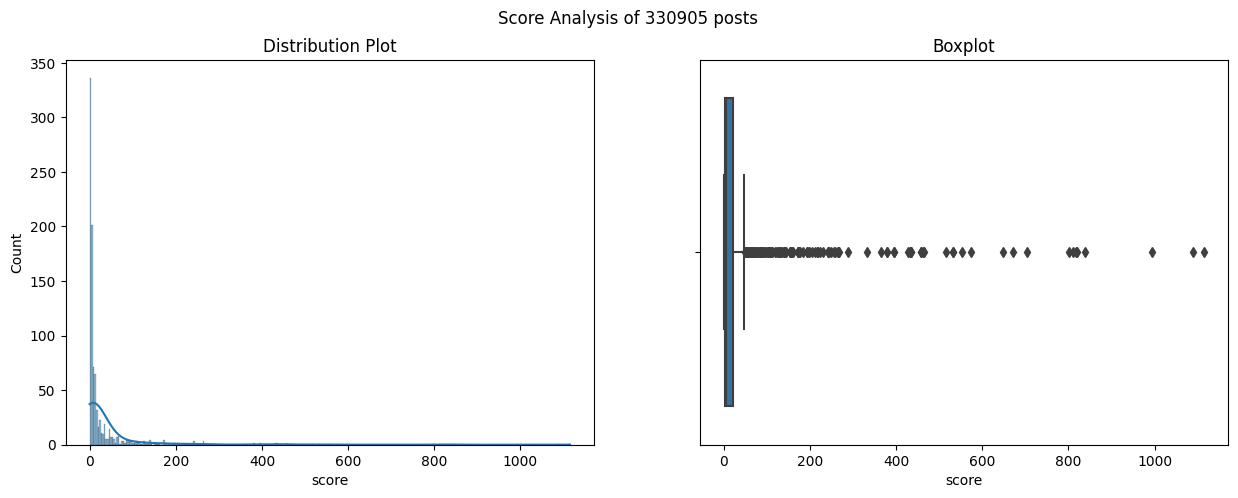

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score Analysis of 330905 posts')

sns.histplot(ax=axes[0], x="score", data=df_title, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df_title)
axes[1].set_title("Boxplot")

plt.show()

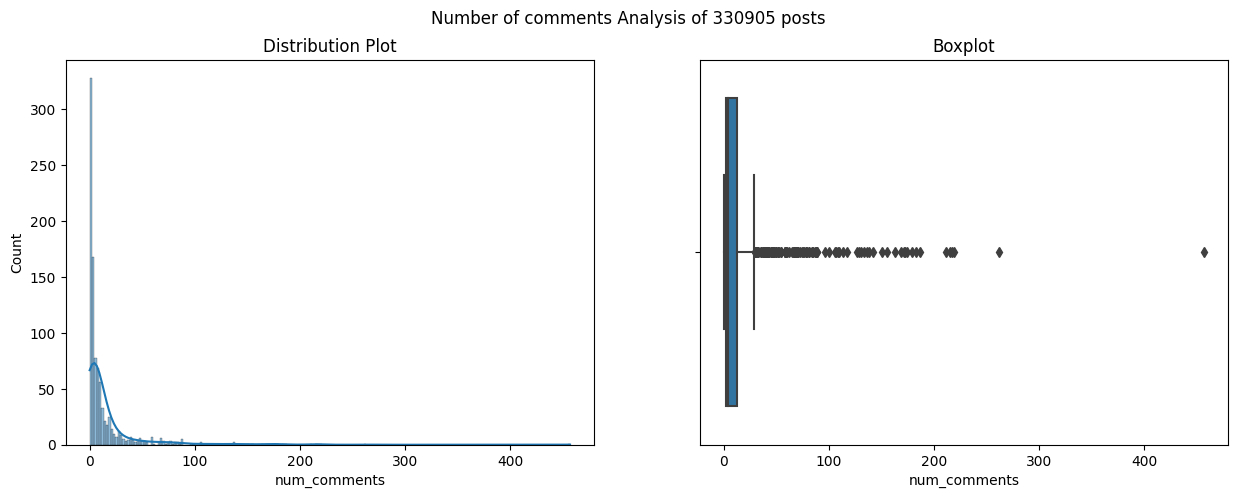

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Number of comments Analysis of 330905 posts')

sns.histplot(ax=axes[0], x="num_comments", data=df_title, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df_title)
axes[1].set_title("Boxplot")

plt.show()

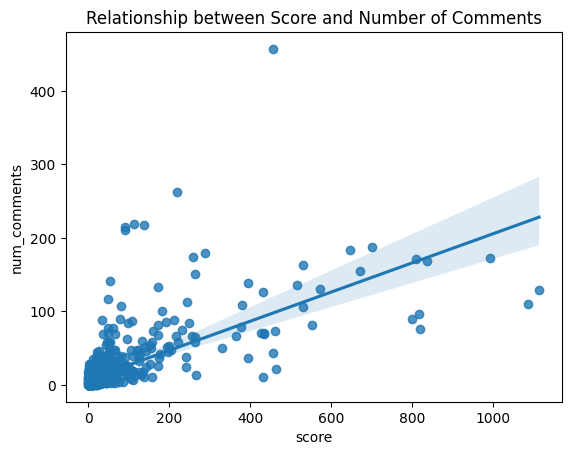

In [11]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between Score and Number of Comments")
plt.show()

## Title Analysis

In [12]:
df_title["title"] = normalize_corpus(df_title["title"])

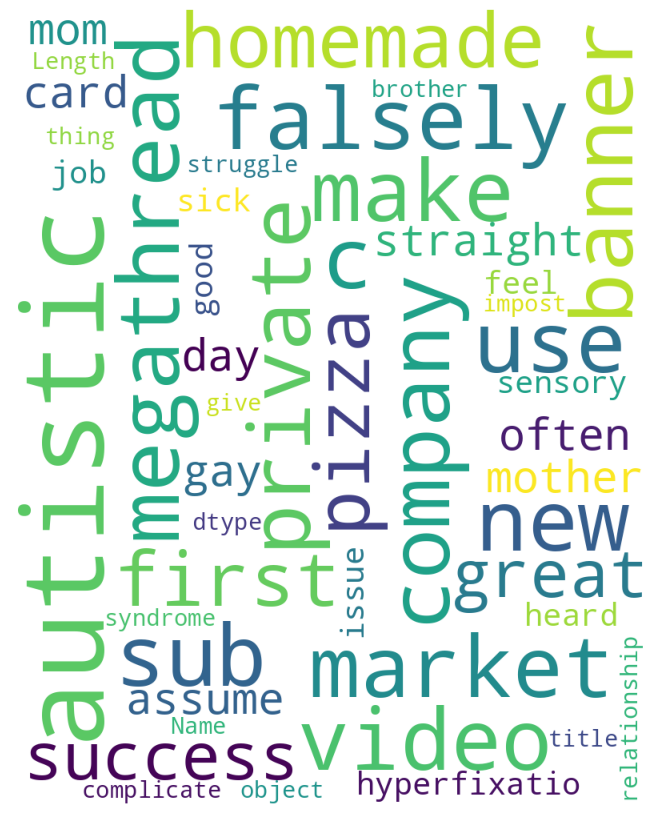

In [13]:
new_stopwords = ["autistic", "autism", "title", 
                 "text", "subreddit", "dtype",
                 "length" "thread", "object",
                 "Name", "asd", "disorder", "spectrum",
                 "megathread"]

stopwords = list(STOPWORDS) #+ new_stopwords
wordcloud = (WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12)
                .generate(str(df_title["title"])))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), 
           facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

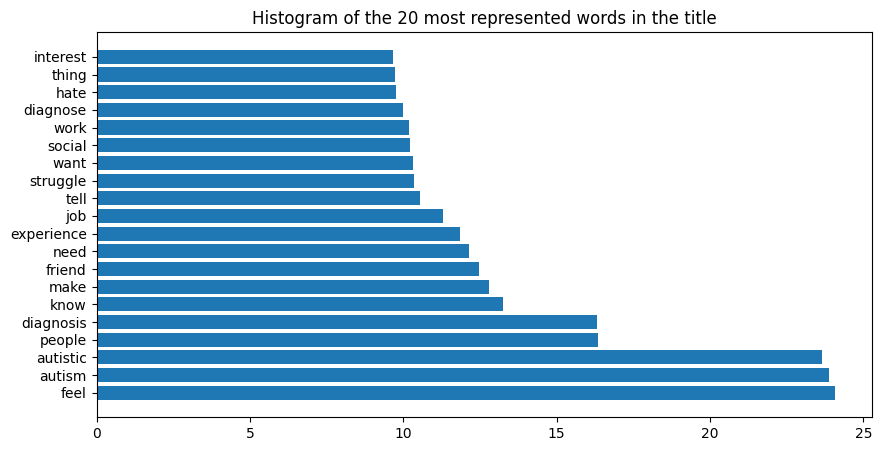

In [14]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_title = vectorizer_tf.fit_transform(df_title['title']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.sum(), columns=["Value"])
top_20_title_word_tf = df_title_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the title")
plt.show()

In [15]:
df_title.to_csv("data/autism-women-title.csv")

In [16]:
del(df_title)
gc.collect()

5871

## Content Analysis

In [17]:
df_text = df[["text", "score", 
              "num_comments"]]

In [18]:
df_text["text"] = normalize_corpus(df_text["text"])

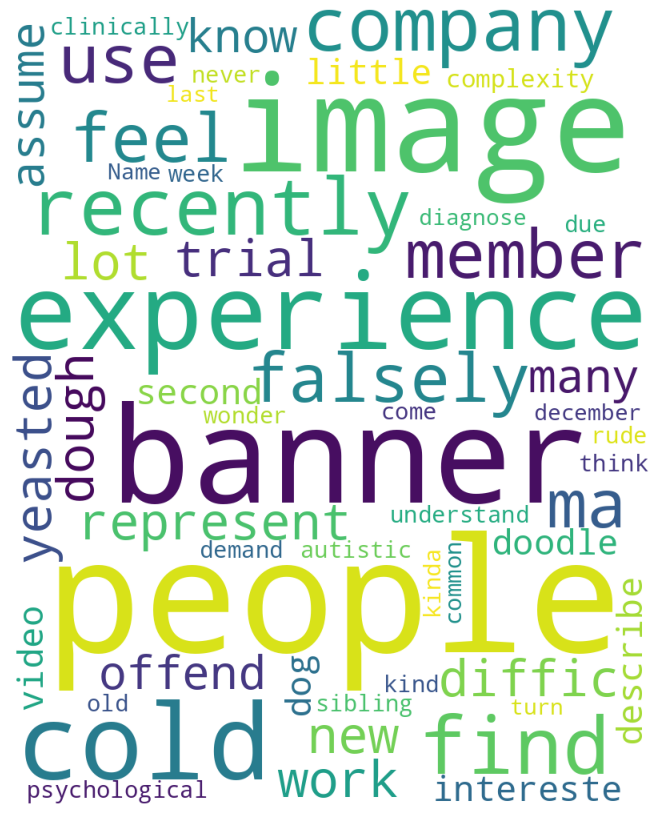

In [19]:
new_stopwords = ["autism", "autist", "length",
                 "object", "object", "text",
                 "sub", "dtype","wee"]

stopwords = list(STOPWORDS) + new_stopwords
wordcloud = (WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12)
                .generate(str(df_text["text"])))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), 
           facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

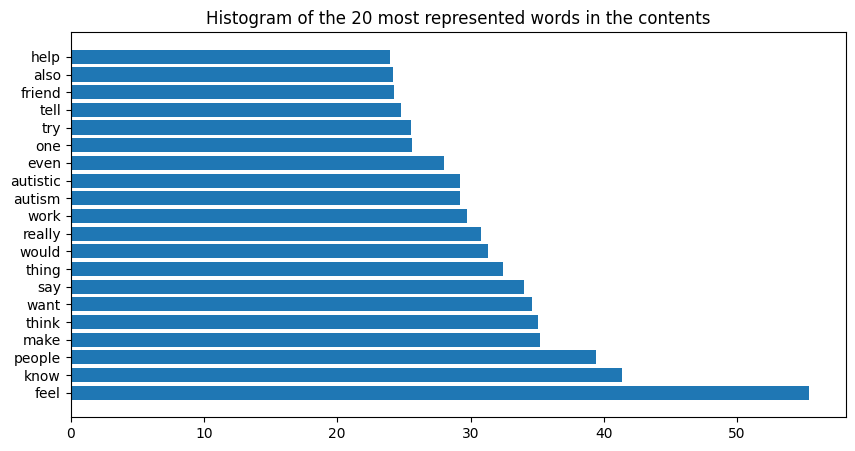

In [20]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_title = vectorizer_tf.fit_transform(df_text['text']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.sum(), columns=["Value"])
top_20_title_word_tf = df_title_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the contents")
plt.show()

In [21]:
df_text.to_csv("data/autism-women-text.csv")